In [8]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from astropy.io import fits
from astropy.table import Table
from scipy.optimize import curve_fit

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

pvhub_dir = os.environ.get('PVHUB_DIR_PATH')
if not pvhub_dir in sys.path: sys.path.append(pvhub_dir)
from pvhub import * # type: ignore

In [16]:
def fit_FP(
    df: pd.DataFrame,
    smin: float = np.log10(70),
    param_boundaries: List[Tuple] = [(0.8, 1.5), (-1.0, -0.8), (-0.2, 0.4), (2.0, 2.4), (2.6, 2.8), (0.04, 0.06), (0.3, 0.4), (0.15, 0.25)],
    pvals_cut: float = 0.01,
    zmin: float = 0.0033,
    zmax: float = 0.1,
    solar_magnitude: float = 4.65,
    mag_high: float = 17.0,
    mag_low: float = 10.0,
    reject_outliers: bool = False,
    use_full_fn: bool = True
          ) -> Tuple[np.ndarray, pd.DataFrame]:

    # Load peculiar velocity model
    pv_model = TwoMPP_SDSS_6dF(verbose=True) # type: ignore

    # Calculate predicted PVs using observed group redshift in CMB frame, and calculate cosmological redshift
    df['v_pec'] = pv_model.calculate_pv(df['ra'].to_numpy(), df['dec'].to_numpy(), df['z_dist_est'].to_numpy())
    df['z_pec'] = df['v_pec'] / LIGHTSPEED
    df['z_cosmo'] = ((1 + df['z_dist_est']) / (1 + df['z_pec'])) - 1
    
    # Calculate predicted true distance and FN integral limits
    red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
    d_H = sp.interpolate.splev(df['z_cosmo'].to_numpy(), dist_spline, der=0)
    df['lmin'] = (solar_magnitude + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_high) / 5.0
    df['lmax'] = (solar_magnitude + 5.0 * np.log10(1.0 + df["zhelio"].to_numpy()) + df["kcor_r"].to_numpy() + df["extinction_r"].to_numpy() + 10.0 - 2.5 * np.log10(2.0 * math.pi) + 5.0 * np.log10(d_H) - mag_low) / 5.0

    # Calculate predicted logdistance-ratios
    d_z = sp.interpolate.splev(df['z_dist_est'].to_numpy(), dist_spline, der=0)
    df['logdist_pred'] = np.log10(d_z / d_H)
    df['r_true'] = df['r'] - df['logdist_pred']

    # If using partial f_n, calculate Sn using the VMAX method
    if not use_full_fn:
        # Get some redshift-distance lookup tables
        red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
        # The comoving distance to each galaxy using group redshift as distance indicator
        dz = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline, der=0)

        # (1+z) factor because we use luminosity distance
        Vmin = (1.0 + zmin)**3 * sp.interpolate.splev(zmin, dist_spline)**3
        Vmax = (1.0 + zmax)**3 * sp.interpolate.splev(zmax, dist_spline)**3
        # Maximum (luminosity) distance the galaxy can be observed given MAG_HIGH (survey limiting magnitude)
        Dlim = 10.0**((mag_high - (df["deVMag_g"] - df['extinction_r']) + 5.0 * np.log10(dz) + 5.0 * np.log10(1.0 + df["zhelio"])) / 5.0)    
        # Find the corresponding maximum redshift
        zlim = sp.interpolate.splev(Dlim, lumred_spline)
        Sn = np.where(zlim >= zmax, 1.0, np.where(zlim <= zmin, 0.0, (Dlim**3 - Vmin)/(Vmax - Vmin)))
        df['Sn'] = Sn
    # If using full f_n, set Sn=1 for all galaxies
    else:
        Sn = 1.0
        df['Sn'] = Sn

    # Fitting the FP iteratively by rejecting galaxies with high chi-square (low p-values) in each iteration
    data_fit = df
    badcount = len(df)
    is_converged = False
    i = 1
    
    while not is_converged:

        Snfit = data_fit["Sn"].to_numpy()

        # The range of the FP parameters' values
        avals, bvals = param_boundaries[0], param_boundaries[1]
        rvals, svals, ivals = param_boundaries[2], param_boundaries[3], param_boundaries[4]
        s1vals, s2vals, s3vals = param_boundaries[5], param_boundaries[6], param_boundaries[7]

        # Fit the FP parameters
        FPparams = sp.optimize.differential_evolution(FP_func, bounds=(avals, bvals, rvals, svals, ivals, s1vals, s2vals, s3vals), 
            args=(0.0, data_fit["z_cmb"].to_numpy(), data_fit["r_true"].to_numpy(), data_fit["s"].to_numpy(), data_fit["i"].to_numpy(), data_fit["er"].to_numpy(), data_fit["es"].to_numpy(), data_fit["ei"].to_numpy(), Snfit, smin, data_fit["lmin"].to_numpy(), data_fit["lmax"].to_numpy(), data_fit["C_m"].to_numpy(), True, False, use_full_fn), maxiter=10000, tol=1.0e-6, workers=-1, seed=42)
        
        # Break from the loop if reject_outliers is set to false
        if reject_outliers == False:
            break
        
        # Calculate the chi-squared 
        chi_squared = Sn * FP_func(FPparams.x, 0.0, df["z_cmb"].to_numpy(), df["r_true"].to_numpy(), df["s"].to_numpy(), df["i"].to_numpy(), df["er"].to_numpy(), df["es"].to_numpy(), df["ei"].to_numpy(), Sn, smin, df["lmin"].to_numpy(), df["lmax"].to_numpy(), df["C_m"].to_numpy(), sumgals=False, chi_squared_only=True)[0]
        
        # Calculate the p-value (x,dof)
        pvals = sp.stats.chi2.sf(chi_squared, np.sum(chi_squared)/(len(df) - 8.0))
        
        # Reject galaxies with p-values < pvals_cut (probabilities of being part of the sample lower than some threshold)
        data_fit = df.drop(df[pvals < pvals_cut].index).reset_index(drop=True)
        
        # Count the number of rejected galaxies
        badcountnew = len(np.where(pvals < pvals_cut)[0])
        
        # Converged if the number of rejected galaxies in this iteration is the same as previous iteration
        is_converged = True if badcount == badcountnew else False
        
        # Set the new count of rejected galaxies
        badcount = badcountnew
        i += 1

    df = data_fit
    
    return FPparams.x, df

In [20]:
col_mapping = {
    "RA": "ra",
    "Dec": "dec",
    "zcmb": "z_cmb",
    "zcmb_group": "z_dist_est",
}

# Load cullan's data
df = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df.rename(col_mapping, axis=1, inplace=True)
df["C_m"] = 1.0

fp_params, _ = fit_FP(
    df=df,
    param_boundaries=[(1.25, 1.3), (-0.86, -0.82), (0.12, 0.18), (2.15, 2.19), (2.68, 2.70), (0.053, 0.056), (0.33, 0.35), (0.21, 0.23)]
)

Loaded model 2M++_SDSS_6dF


/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/venv/lib/python3.11/site-packages/scipy/optimize/_differentialevolution.py:488: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


In [21]:
fp_params

array([ 1.25000023, -0.82000061,  0.12000006,  2.19      ,  2.68000003,
        0.056     ,  0.34999958,  0.22999225])

In [9]:
df.columns

Index(['PGC', 'coords', 'objid', 'specObjId', 'plate', 'RA', 'Dec', 'l', 'b',
       'deVMag_g', 'deVMagErr_g', 'deVMagErr_r', 'deVMagErr_r.1', 'deVRad_r',
       'deVRadErr_r', 'deVAB_r', 'deVABErr_r', 'extinction_g', 'extinction_r',
       'kcor_r', 'kcor_g', 'absmag_r', 'zhelio', 'zhelioerr', 'zcmb',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'IDgroupT17', 'NgroupT17',
       'zcmb_group', 'M', 'in_mask', 'nbar', 'r', 'er', 's', 'es', 'i', 'ei',
       'logdist', 'logdist_err', 'logdist_alpha', 'logdist_corr',
       'logdist_corr_err', 'logdist_corr_alpha'],
      dtype='object')

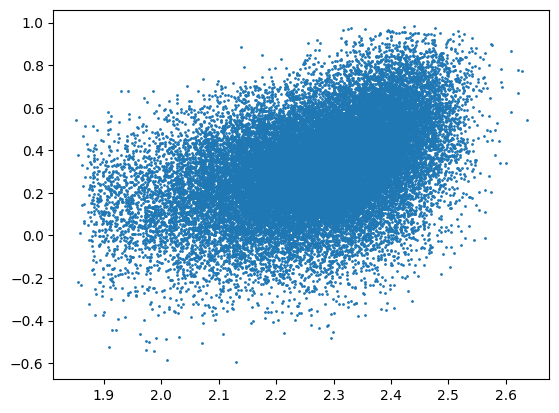

In [5]:
plt.scatter(df['i'], df['r'], s=1)

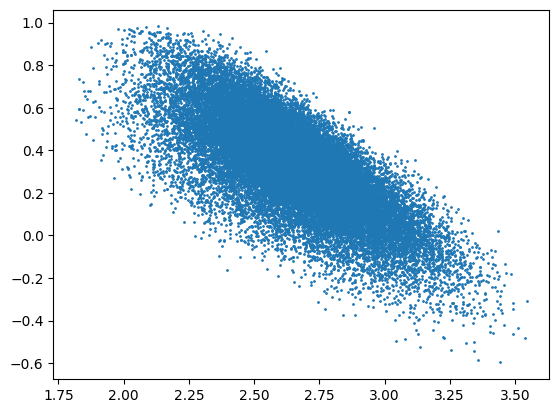

In [6]:
plt.scatter(df['s'], df['r'], s=1)

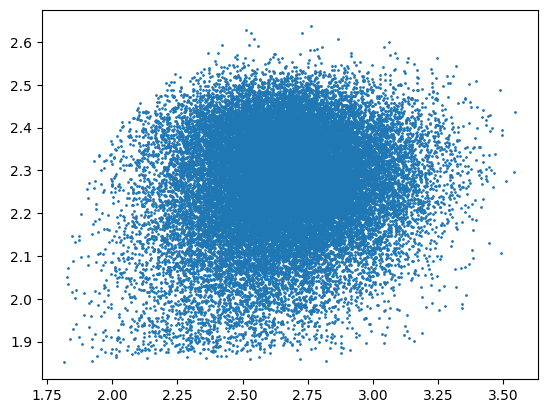

In [7]:
plt.scatter(df['s'], df['i'], s=1)